## yolo test

```bash
uv add "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.53" "onnxruntime"
```

use this to train additional images ...

```python
results = model.train(data="coco8.yaml", epochs=100, imgsz=640)
```

In [ ]:
import onnx
import onnxruntime
import onnxslim

print("onnx version: ", onnx.__version__)
print("onnxruntime version: ", onnxruntime.__version__)
print("onnxsim version: ", onnxslim.__version__)


In [11]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')
# model.export(format='onnx', simplify=True)

In [12]:
results = model("bailey.jpeg")
results[0].show()


image 1/1 /Users/Gerry.Wagner/develop/psueng/sweng-894-capstone/python/bailey.jpeg: 640x480 1 dog, 1 couch, 1 remote, 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
import torch

# if torch.backends.mps.is_available():
#     device = "mps"  # Metal on macOS
# elif torch.cuda.is_available():
#     device = "cuda"
# else:
#     device = "cpu"
    
# print("Using device:", device)

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the image
image_path = "bailey.jpeg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the SAM model
sam_checkpoint = "/Users/Gerry.Wagner/Downloads/sam_vit_h_4b8939.pth"  # Download from Meta's GitHub
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Generate masks
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_rgb)

In [ ]:
# # Draw bounding boxes
# for mask in masks:
#     x, y, w, h = cv2.boundingRect(mask["segmentation"].astype(np.uint8))
#     cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

# # Show result
# plt.figure(figsize=(10, 10))
# plt.imshow(image_rgb)
# plt.axis("off")
# plt.title(f"{len(masks)} masks detected")
# plt.show()

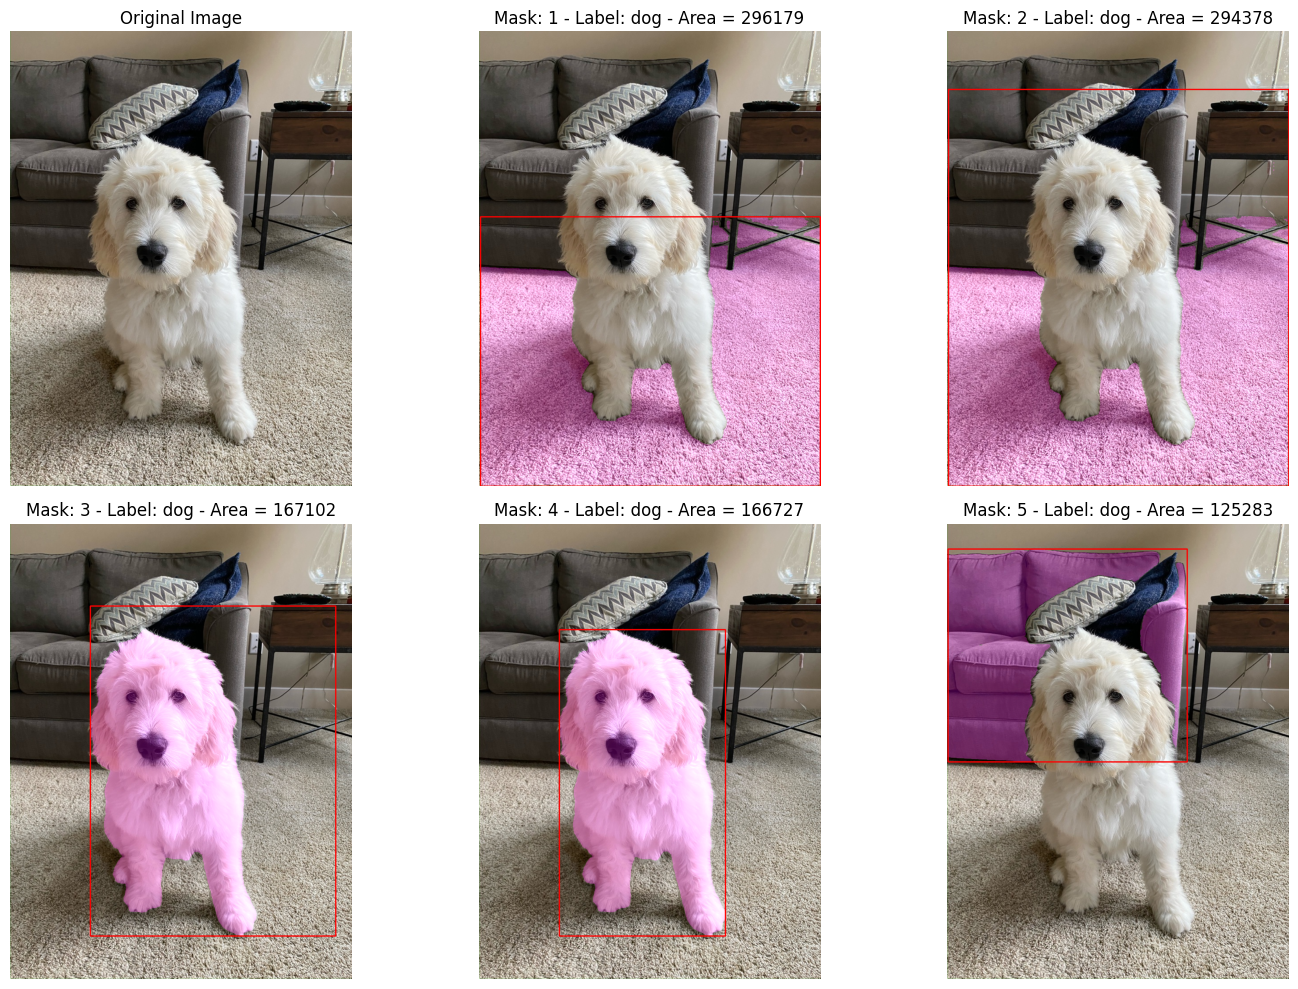

In [ ]:
import clip

# Load CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

# Get top 5 largest masks
top_5_masks = sorted_masks[:5]

# Visualize the top 5 masks
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# Display each of the top 5 masks
# colors = [(np.random.random(3)) for _ in range(5)]
colors = [(0.5,0.0,0.5) for _ in range(5)]

labels = ["dog", "couch", "remote"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {label}") for label in labels]).to(device)

for i, mask_data in enumerate(top_5_masks):
    plt.subplot(2, 3, i+2)
    
    # Create a colored mask overlay
    mask = mask_data['segmentation']
    colored_mask = np.zeros_like(image_rgb, dtype=np.uint8)
    colored_mask[mask] = (np.array(colors[i]) * 255).astype(np.uint8)
    
    # Blend the mask with the original image
    alpha = 0.5
    blended = cv2.addWeighted(image_rgb, 1, colored_mask, alpha, 0)

    x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
    cv2.rectangle(blended, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Crop the mask region from the image
    mask_region = image_rgb[y:y+h, x:x+w]
    mask_pil = Image.fromarray(mask_region.astype(np.uint8))
    mask_input = preprocess(mask_pil).unsqueeze(0).to(device)

    # Use CLIP to classify the mask region
    with torch.no_grad():
        image_features = clip_model.encode_image(mask_input)
        text_features = clip_model.encode_text(text_inputs)
        logits_per_image, _ = clip_model(mask_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Get the label with the highest probability
    label_index = np.argmax(probs)
    label = labels[label_index]

    plt.imshow(blended)
    plt.title(f"Mask: {i+1} - Label: {label} - Area = {mask_data['area']}")
    plt.axis('off')

plt.tight_layout()
plt.show()